In [17]:
import numpy as np
import pandas as pd
import scipy 
import seaborn as sns
import shap
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
import numpy as np 
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import sys
import os 
current_dir = os.getcwd()
src_dir = os.path.join(current_dir, '..', 'src')
sys.path.append(src_dir)
from load_data import *

In [18]:
df_param = param_df()
df_diff = diff_df()
df_one = life_df()
df_rpt = rpt_df()
df_f_info = form_df()
df_electrode_info = electrode_df()

In [19]:
df_all = df_f_info.merge(df_param, on = 'seq_num')
df_all = df_all.merge(df_rpt, on = 'seq_num')
df_all = df_all.merge(df_one, on = 'seq_num')
df_all = df_all.merge(df_diff, on = ['seq_num', 'cycle_index'])
df_all = df_all.merge(df_electrode_info, on = ['seq_num', 'cycle_index'])

### Percentage increase in cycle life used in this paper 

##### Range of the RPT C/20 discharge capacity for the first cycle

In [4]:
df_all_0 = df_all[df_all.cycle_index == 0]
df_all_0.rpt_low_cap.max(), df_all_0.rpt_low_cap.min()

(0.2730868688, 0.2399530382)

##### Range of the 0.75C aging cycle discharge capacity for the first cycle

In [5]:
df_all_0.regu_cap.max(), df_all_0.regu_cap.min()

(0.251306868, 0.2390064789)

In [6]:
norm = df_all[(df_all.formation_charge_current_1<0.12)&(df_all.formation_charge_current_2<0.12)&(df_all.formation_temperature<55)]
high_T = df_all[df_all.formation_temperature == 55]
high_curr = df_all[(df_all.formation_charge_current_1>=0.24)&(df_all.formation_charge_current_2>=0.24)&(df_all.formation_temperature<55)]

##### Improvement for the high-temperature formation protocols #####

In [7]:
a = norm.regu_life.mean()
b = high_T.regu_life.mean()
(b-a)/a

0.6088553933113516

##### Improvement for the fast formation protocols

In [8]:
a = norm.regu_life.mean()
b = high_curr.regu_life.mean()
(b-a)/a

0.5143263977996869

# SHAP analysis 

### S.I. for one metric 

In [4]:
def get_optimal_param_shap(chosen, y, columns, model, seed, plot, normalize):
    
    X = chosen[columns]
    X.rename(columns={'formation_temperature' : "T",  'formation_charge_current_1': "CC$_{1}$", 'formation_cutoff_voltage_1': "V$_{transition}$",
       'formation_charge_current_2': "CC$_{2}$", 'formation_verification_repeat': 'n$_{verification}$', 'ocv_time': 't$_{OCV}$'}, inplace=True)
    
    if normalize:
        chosen[y] = (chosen[y] - chosen[y].min())/(chosen[y].max() - chosen[y].min())
        
    
    if model == 'xgb':
        param_grid = {'max_depth':[4, 6, 10, 16],
                 'reg_lambda':[1, 2.5, 3, 4, 6],
                'gamma': [0],
                 'n_estimators': [2 ,4, 8, 10, 16, 20, 30],
                'random_state': [seed]}
        model = RandomizedSearchCV(xgb.XGBRegressor(), param_grid, refit = True, verbose = 1, n_jobs=-1) 
    
    elif model == 'forest':
        param_grid = {'max_depth': randint(3, 12),
                 'min_samples_leaf': randint(2, 10),
                 'min_samples_split': randint(2, 11),
                 'n_estimators': randint(2, 50),
                'random_state': [seed]
                    }
    
        model = RandomizedSearchCV(RandomForestRegressor(), param_grid, refit = True, verbose = 1, n_jobs=-1, n_iter = 150) 
   
    elif model == 'dummy':
        model = DummyRegressor(strategy="mean")
        
    
#     conditions = ['formation_charge_current_1','formation_cutoff_voltage_1','formation_charge_current_2', 'formation_temperature', 
#                 'formation_verification_repeat', 'ocv_time']

    conditions = columns
    
    df_uniq = chosen.groupby(conditions).size().reset_index(name='count')
    train_no_dup, test_no_dup = train_test_split(df_uniq, test_size=0.2, random_state=seed)
    train = chosen.merge(train_no_dup, how = 'inner' ,indicator=False)
    test = chosen.merge(test_no_dup, how = 'inner' ,indicator=False) 

    X_train = train[columns]
    y_train = train[y]
    X_test = test[columns]
    y_test = test[y]
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    
    model.fit(X_train, y_train)

    y_test = np.ravel(y_test)
    y_train = np.ravel(y_train)
    
    predictions = model.predict(X_test)
    trains = model.predict(X_train)

    RMSE = mean_squared_error(trains, y_train)**0.5
    MAE = mean_absolute_error(trains, y_train)
    MAPE = mean_absolute_percentage_error(trains, y_train)
    R_2 = pearsonr(trains, y_train)

    RMSE_test = mean_squared_error(predictions, y_test)**0.5
    MAE_test = mean_absolute_error(predictions, y_test)
    MAPE_test = mean_absolute_percentage_error(predictions, y_test)
    R_2_test = pearsonr(predictions, y_test)
    
    print('Train MAPE = '+str(round(MAPE, 3)) , 'Train RMSE = '+str(np.around(RMSE,3)),
                            'Test MAPE = '+str(round(MAPE_test,3)), 'Test RMSE = '+str(np.around(RMSE_test,3)))
    if plot:
        fig, ax = plt.subplots(dpi = 150)
        ax.scatter(y_train, trains, label = 'trainings')
        ax.scatter(y_test, predictions, label = 'predictions')

        ax.plot(y_train, y_train,color="gold")
        ax.set_ylabel('Predicted Values')
        ax.set_xlabel('Real Values')
        ax.set_title('Random Forest Predictions')

        ax.annotate('       Train',(0.05,0.9),fontsize=14,color='tab:blue',
                     xycoords='axes fraction')
        ax.annotate('MAPE = '+ "{:.2f}".format(MAPE*100),(0.05,0.84),fontsize=14,color='tab:blue',
                     xycoords='axes fraction')
        ax.annotate('RMSE = '+str(np.around(RMSE,1)),(0.05,0.78),fontsize=14,color='tab:blue',
                     xycoords='axes fraction')


        ax.annotate('       Test',(0.6,(0.9-0.6)),fontsize=14,color='tab:orange',
                     xycoords='axes fraction')
        ax.annotate('MAPE = '+"{:.2f}".format(MAPE_test*100),(0.6,(0.84-0.6)),fontsize=14,color='tab:orange',
                     xycoords='axes fraction')
        ax.annotate('RMSE = '+str(np.around(RMSE_test,1)),(0.6,(0.78-0.6)),fontsize=14,color='tab:orange',
                     xycoords='axes fraction')

#     plt.setp(ax, ylim=plt.ylim())
#     plt.savefig('pred.png', transparent = True)
#     np.around(MAPE_test*100, 1)
    
    
    return model, X,  RMSE, MAPE, RMSE_test, MAPE_test, R_2[0], R_2_test[0]

In [5]:
def get_feature_importance(model, X, label):
    
    # fig = plt.subplots(dpi = 150)
    explainer = shap.TreeExplainer(model.best_estimator_)
    shap_values = explainer(X)
#     cmap = sns.color_palette("light:royalblue", as_cmap=True)

    feature_names = [
        a + "(" + str(b)  + ')' for a,b in zip(X.columns, (np.abs(shap_values.values).mean(0)).round(2))
    ]
    
    d = {'names': X.columns, 'values': (np.abs(shap_values.values).mean(0)).round(2)}
    df = pd.DataFrame(d)
    
    # shap.summary_plot(shap_values, X, plot_size=(7,5), sort=True, show = False)
    # plt.xlabel(label)
    
    return explainer, df 

    

## Generating the matrix plot

In [6]:
cycle = 127
r_name = 'r_d_0_10s'
df_diff_0 = df_diff[df_diff.cycle_index == 0][[r_name, 'seq_num']]
df_diff_0 = df_diff_0.rename(columns={r_name: r_name + '_0'}) 
df_diff_cycle = df_diff[df_diff.cycle_index == cycle][[r_name, 'seq_num']]
df_diff_cycle = df_diff_cycle.rename(columns={r_name: r_name + '_' + str(cycle)}) 
df_diff_chosen = df_diff_0.merge(df_diff_cycle, on = 'seq_num')

df_rpt_0 = df_rpt[df_rpt.cycle_index == 0][['rpt_low_cap', 'rpt_med_cap', 'regu_cap', 'seq_num']]
df_rpt_0 = df_rpt_0.rename(columns={'rpt_low_cap': 'rpt_low_cap_0', 'rpt_med_cap': 'rpt_med_cap_0', 'regu_cap': 'regu_cap_0'}) 
df_rpt_cycle = df_rpt[df_rpt.cycle_index == cycle][['rpt_low_cap', 'rpt_med_cap', 'regu_cap', 'seq_num']]
df_rpt_cycle = df_rpt_cycle.rename(columns={'rpt_low_cap': 'rpt_low_cap_' + str(cycle), 'rpt_med_cap': 'rpt_med_cap_' + str(cycle), 'regu_cap': 'regu_cap_' + str(cycle)}) 
df_rpt_chosen = df_rpt_0.merge(df_rpt_cycle, on = 'seq_num')

param_df_chosen = df_param[['seq_num', 
       'formation_temperature', 'cell_id', 'ocv_time',
       'wetting_hold_time', 'formation_charge_current_1',
       'formation_cutoff_voltage_1', 'formation_charge_current_2', 
       'formation_discharge_current', 'formation_verification_current',
       'formation_verification_repeat']]

df_input = pd.merge(param_df_chosen, pd.merge(df_rpt_chosen, pd.merge(df_diff_chosen, df_one, on = 'seq_num'), on = 'seq_num'), on = 'seq_num')
df_input = df_input.merge(df_f_info, on = 'seq_num')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(141, 6) (37, 6) (141,) (37,)
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Train MAE = 0.1995337840983113 Train RMSE = 0.1 Test MAE = 0.39787316474077794 Test RMSE = 0.2


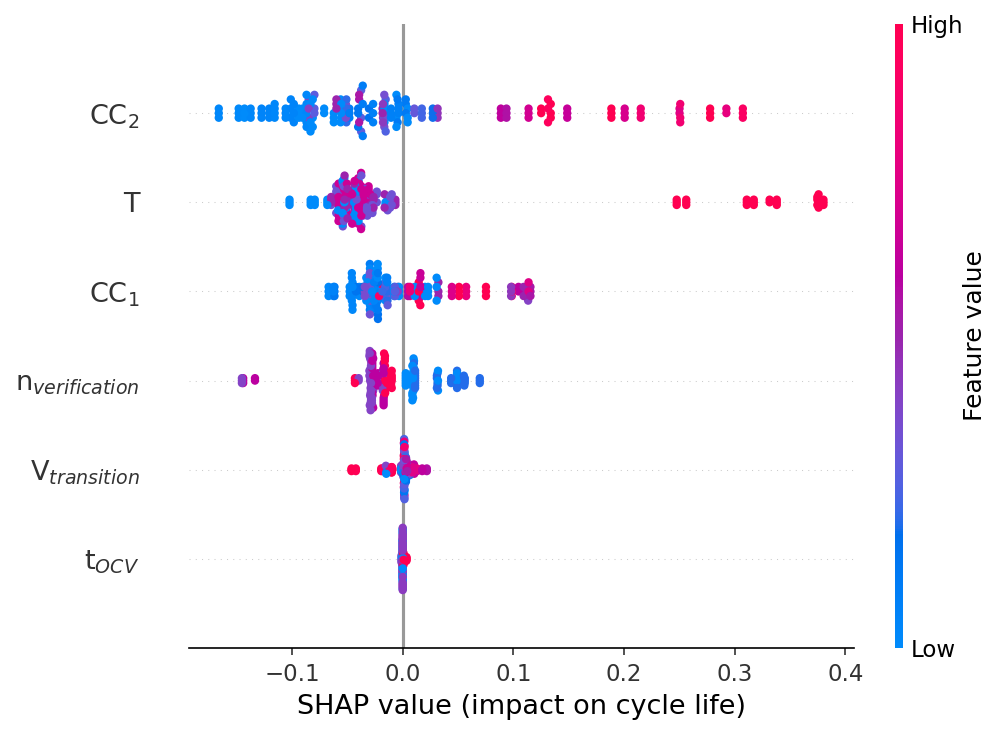

In [10]:
target = 'regu_life'

chosen = df_input
plot = 0
normalize = 1
seed = 726 ### -> depending on the seed, the results may change, but T and CC2 should always be the most important features 

model = 'forest' 
columns = ['formation_charge_current_1','formation_cutoff_voltage_1','formation_charge_current_2', 'formation_temperature', 
                'formation_verification_repeat', 'ocv_time']
model, X, rmse, mape, _, _, _, _ = get_optimal_param_shap(chosen, target, columns, model, seed, plot, normalize)

label = 'SHAP value (impact on cycle life)'
explainer, d = get_feature_importance(model, X, label)
# plt.savefig('Figs/SI_shap_cycle_life.pdf', transparent = True, bbox_inches='tight')


## S.I. All parameters and without formation metrics 

In [7]:
# set random seeds 
# rng = np.random.default_rng(12345) ### seed for the random number generator and results may change depending on the seed 
# rints = rng.integers(low=0, high=100, size=1)

rints = np.array([726])

df = pd.DataFrame()
# targets = ['1st_ch_cap', '1st_disch_cap',  'r_d_5_30s', 'regu_knee', 'regu_life']
targets = ['rpt_low_cap_0', 'regu_cap_0',  'r_d_0_10s_0', 'rpt_low_cap_' + str(cycle), 'regu_cap_'+ str(cycle),  'r_d_0_10s_' + str(cycle), 'regu_knee', 'regu_life']
columns = ['formation_temperature',  'formation_charge_current_1', 'formation_cutoff_voltage_1',
       'formation_charge_current_2', 'formation_verification_repeat', 'ocv_time']

plot = 0
normalize = 1
model = 'forest'

result = np.zeros((len(columns)+2, len(targets)))
df_all_2 = df_input

for i in range(len(targets)):
    target = targets[i]
    for r in range(len(rints)):
        rint = rints[r]
        chosen = df_all_2[df_all_2.seq_num.isin(batch_1)]
        chosen = chosen[[target]+columns].dropna(axis = 'rows')
        chosen = chosen.astype('float')
        model, X, _, _, rmse, _, _, r_2 = get_optimal_param_shap(chosen, target, columns, model, rint, plot, normalize)
        explainer, d = get_feature_importance(model, X, '')
        d.loc[len(d.index)] = ['rmse', rmse] 
        d.loc[len(d.index)+1] = ['r_2', r_2]
        if r == 0:
            df = d
        else:
            df = df.merge(d, how = 'left', on = 'names')
    result[:, i] = df.iloc[:, 1:].mean(axis = 1)

### please note that the model prediction errors may change 

(142, 6) (36, 6) (142,) (36,)
Fitting 5 folds for each of 150 candidates, totalling 750 fits



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train MAPE = 0.102 Train RMSE = 0.08 Test MAPE = 0.173 Test RMSE = 0.157
(142, 6) (36, 6) (142,) (36,)
Fitting 5 folds for each of 150 candidates, totalling 750 fits



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train MAPE = 0.189 Train RMSE = 0.129 Test MAPE = 0.214 Test RMSE = 0.159
(142, 6) (36, 6) (142,) (36,)
Fitting 5 folds for each of 150 candidates, totalling 750 fits



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train MAPE = 0.387 Train RMSE = 0.083 Test MAPE = 0.349 Test RMSE = 0.048
(142, 6) (36, 6) (142,) (36,)
Fitting 5 folds for each of 150 candidates, totalling 750 fits



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train MAPE = 0.108 Train RMSE = 0.089 Test MAPE = 0.196 Test RMSE = 0.157
(142, 6) (36, 6) (142,) (36,)
Fitting 5 folds for each of 150 candidates, totalling 750 fits



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train MAPE = 0.177 Train RMSE = 0.117 Test MAPE = 0.207 Test RMSE = 0.152
(142, 6) (36, 6) (142,) (36,)
Fitting 5 folds for each of 150 candidates, totalling 750 fits



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train MAPE = 0.043 Train RMSE = 0.068 Test MAPE = 0.054 Test RMSE = 0.063
(142, 6) (36, 6) (142,) (36,)
Fitting 5 folds for each of 150 candidates, totalling 750 fits



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train MAPE = 0.364 Train RMSE = 0.169 Test MAPE = 0.58 Test RMSE = 0.212
(142, 6) (36, 6) (142,) (36,)
Fitting 5 folds for each of 150 candidates, totalling 750 fits



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train MAPE = 0.199 Train RMSE = 0.071 Test MAPE = 0.424 Test RMSE = 0.129


Text(0, 0.5, 'Mean |SHAP Value|')

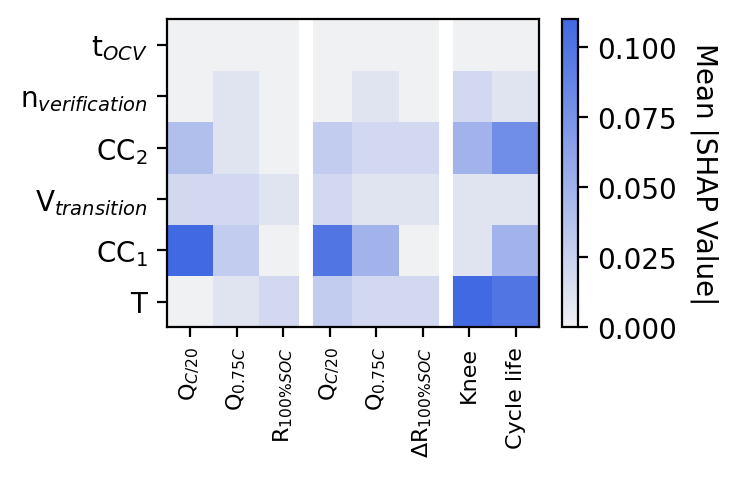

In [8]:
result_wo_error = result[:-2, :]
# result_wo_error_norm = (result_wo_error - result_wo_error.min(axis = 0))/(result_wo_error.max(axis = 0) - result_wo_error.min(axis = 0))
sub = result_wo_error
fig, ax = plt.subplots(figsize = (3, 2), dpi = 200)
colormap = sns.color_palette("light:royalblue", as_cmap=True)
c = plt.pcolor(sub, cmap = colormap, vmax = sub.max(), vmin = sub.min())
cbar = fig.colorbar(c, ax = ax)
ax.set_xticks(np.arange(sub.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(sub.shape[0]) + 0.5, minor=False)
plt.xticks(rotation = 90)
cbar.ax.get_yaxis().labelpad = 15
ynames = [ "T",  "CC$_{1}$", "V$_{transition}$", "CC$_{2}$", 'n$_{verification}$', 't$_{OCV}$']
ax.set_yticklabels(ynames)

# names = ['1$^{st}$ cycle Q$_{charge}$', '1$^{st}$ cycle Q$_{discharge}$', '$\Delta$Q$_{C/20}$', '$\Delta$R$_{SOC@0\%}$', 'knee', 'cycle life']
names = ['Q$_{C/20}$', 'Q$_{0.75C}$', 'R$_{100\% SOC}$', 'Q$_{C/20}$', 'Q$_{0.75C}$', '$\Delta$R$_{100\%SOC}$', 'Knee', 'Cycle life']

ax.set_xticklabels(names, rotation = 90, fontsize = 8)
ax.axvline(x=3, color='white', linewidth = 5)
ax.axvline(x=6, color='white', linewidth = 5)
cbar.ax.set_ylabel('Mean |SHAP Value|', rotation=270)
# plt.savefig('Figs/SI_SHAP_matrix.pdf', transparent = True, bbox_inches='tight')

## Remove the unimportant parameters and add in formation metrics 

In [9]:
# rng = np.random.default_rng(12345)
# rints = rng.integers(low=0, high=100, size=1) ### seed for the random number generator and results may change depending on the seed 
rints = [726]
df = pd.DataFrame()
# targets = ['1st_ch_cap', '1st_disch_cap',  'r_d_5_30s', 'regu_knee', 'regu_life']
targets = ['1st_ch_cap', 'disch_cap_with_cv', 'rpt_low_cap_' + str(cycle), 'regu_cap_'+ str(cycle),  r_name + '_' + str(cycle), 'regu_knee', 'regu_life', 'e_throughput']
columns = ['formation_temperature',  'formation_charge_current_1', 'formation_cutoff_voltage_1',
       'formation_charge_current_2']

plot = 0
normalize = 1
model = 'forest'

result = np.zeros((len(columns)+2, len(targets)))
df_all_2 = df_input

for i in range(len(targets)):
    target = targets[i]
    for r in range(len(rints)):
        rint = rints[r]
        chosen = df_all_2[df_all_2.seq_num.isin(batch_1)]
        chosen = chosen[[target]+columns].dropna(axis = 'rows')
        chosen = chosen.astype('float')
        model, X, _, _, rmse, _, _, r_2 = get_optimal_param_shap(chosen, target, columns, model, rint, plot, normalize)
        explainer, d = get_feature_importance(model, X, '')
        d.loc[len(d.index)] = ['rmse', rmse] 
        d.loc[len(d.index)+1] = ['r_2', r_2]
        if r == 0:
            df = d
        else:
            df = df.merge(d, how = 'left', on = 'names')
    result[:, i] = df.iloc[:, 1:].mean(axis = 1)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(142, 4) (36, 4) (142,) (36,)
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Train MAPE = 0.274 Train RMSE = 0.084 Test MAPE = 0.568 Test RMSE = 0.213
(142, 4) (36, 4) (142,) (36,)
Fitting 5 folds for each of 150 candidates, totalling 750 fits



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train MAPE = 0.114 Train RMSE = 0.085 Test MAPE = 0.195 Test RMSE = 0.147
(142, 4) (36, 4) (142,) (36,)
Fitting 5 folds for each of 150 candidates, totalling 750 fits



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train MAPE = 0.108 Train RMSE = 0.083 Test MAPE = 0.17 Test RMSE = 0.139
(142, 4) (36, 4) (142,) (36,)
Fitting 5 folds for each of 150 candidates, totalling 750 fits



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train MAPE = 0.177 Train RMSE = 0.117 Test MAPE = 0.211 Test RMSE = 0.154
(142, 4) (36, 4) (142,) (36,)
Fitting 5 folds for each of 150 candidates, totalling 750 fits



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train MAPE = 0.044 Train RMSE = 0.069 Test MAPE = 0.055 Test RMSE = 0.062
(142, 4) (36, 4) (142,) (36,)
Fitting 5 folds for each of 150 candidates, totalling 750 fits



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train MAPE = 0.327 Train RMSE = 0.157 Test MAPE = 0.502 Test RMSE = 0.197
(142, 4) (36, 4) (142,) (36,)
Fitting 5 folds for each of 150 candidates, totalling 750 fits



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train MAPE = 0.225 Train RMSE = 0.079 Test MAPE = 0.481 Test RMSE = 0.139
(142, 4) (36, 4) (142,) (36,)
Fitting 5 folds for each of 150 candidates, totalling 750 fits



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train MAPE = 0.195 Train RMSE = 0.069 Test MAPE = 0.452 Test RMSE = 0.128


Text(0, 0.5, 'Mean |SHAP Value|')

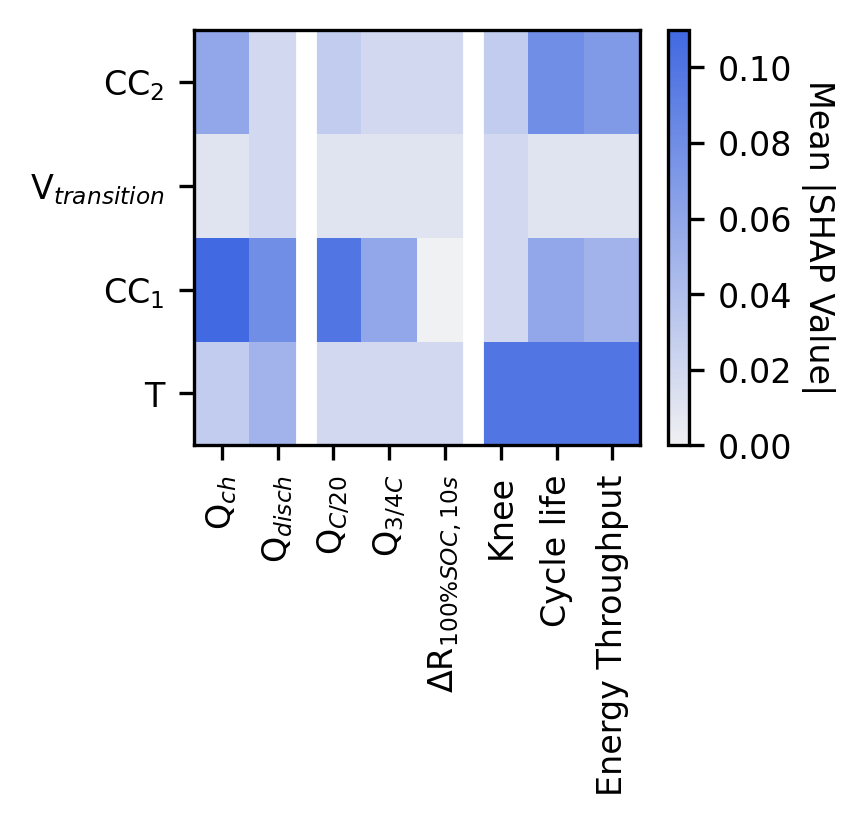

In [10]:
result_wo_error = result[:-2, :]
# result_wo_error_norm = (result_wo_error - result_wo_error.min(axis = 0))/(result_wo_error.max(axis = 0) - result_wo_error.min(axis = 0))
sub = result_wo_error
fig, ax = plt.subplots(figsize = (2.4, 1.8), dpi = 300)
colormap = sns.color_palette("light:royalblue", as_cmap=True)
c = plt.pcolor(sub, cmap = colormap, vmax = sub.max(), vmin = sub.min())
cbar = fig.colorbar(c, ax = ax)
ax.set_xticks(np.arange(sub.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(sub.shape[0]) + 0.5, minor=False)
plt.xticks(rotation = 90)
cbar.ax.get_yaxis().labelpad = 15
ynames = [ "T",  "CC$_{1}$", "V$_{transition}$", "CC$_{2}$"]
ax.set_yticklabels(ynames, fontsize = 8)

# names = ['1$^{st}$ cycle Q$_{charge}$', '1$^{st}$ cycle Q$_{discharge}$', '$\Delta$Q$_{C/20}$', '$\Delta$R$_{SOC@0\%}$', 'knee', 'cycle life']
names = ['Q$_{ch}$', 'Q$_{disch}$', 'Q$_{C/20}$', 'Q$_{3/4C}$', '$\Delta$R$_{100\%SOC, 10s}$', 'Knee', 'Cycle life', 'Energy Throughput']

ax.set_xticklabels(names, rotation = 90, fontsize = 8)
ax.axvline(x=2, color='white', linewidth = 5)
ax.axvline(x=5, color='white', linewidth = 5)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
cbar.ax.tick_params(axis='y', labelsize=8)
cbar.ax.set_ylabel('Mean |SHAP Value|', rotation=270, fontsize = 8, labelpad = 10)
# plt.savefig('Figs/SHAP_subset.svg', transparent = True, bbox_inches='tight')

# Plot the degradation trajectories 

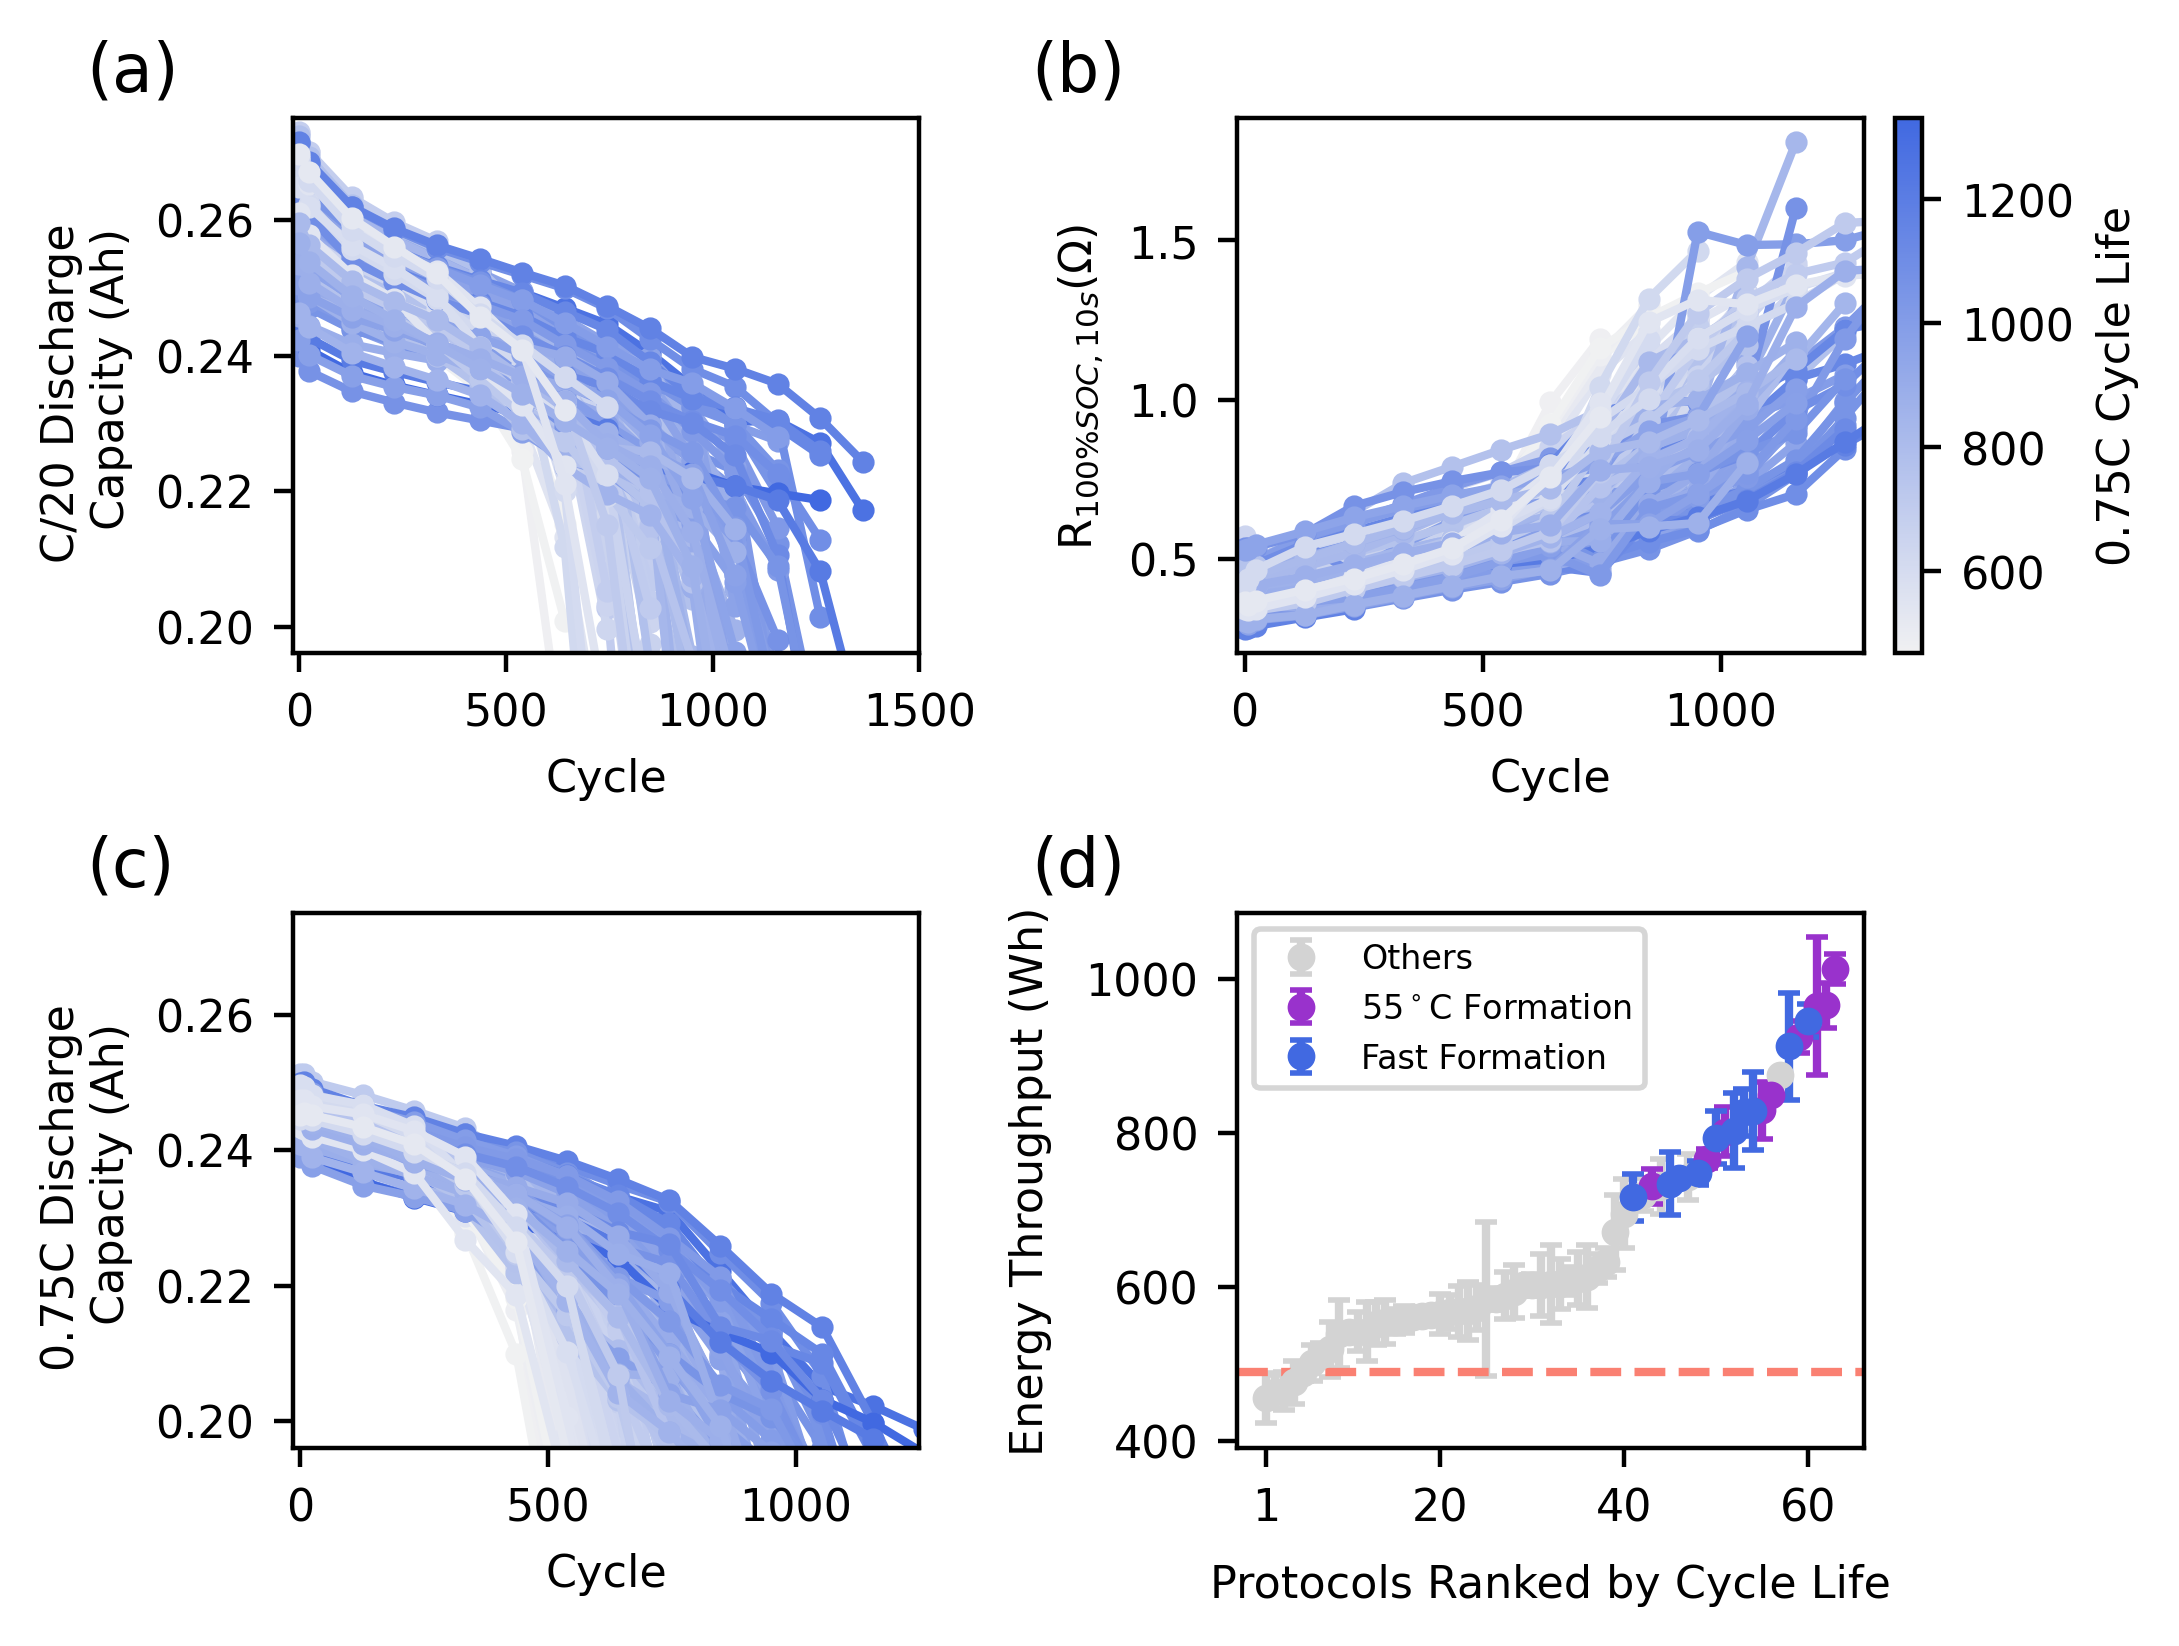

In [20]:
num_cols = 2
num_rows = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(8/3*num_cols, 2*num_rows), dpi=400, constrained_layout=True)
axs = axs.ravel()

# Assuming these are the three different life_names corresponding to each subplot
life_name = 'regu_life'

# Settings for each subplot
targets = ['rpt_low_cap', 'r_d_0_10s', 'regu_cap']
ylabels = ['C/20 Discharge \n Capacity (Ah)',  'R$_{100\%SOC, 10s}$(Ω)', '0.75C Discharge \n Capacity (Ah)']
c_names = ['0.75C Cycle Life']*3

df_all_0 = df_all[df_all.cycle_index == 0]

for i in range(3):
    # Normalization and color map for each subplot
    norm = plt.Normalize(vmin=np.min(df_one[life_name]), vmax=np.max(df_one[life_name]))
    cmap = sns.color_palette("light:royalblue", as_cmap=True)
    if i == 1:
        for seq_num in batch_1:
            chosen = df_diff[df_diff.seq_num == seq_num]
            if not (chosen.empty | (seq_num == 270)):
                rs = chosen[targets[i]]
                rs_val = [rs.iloc[0]] + [r + rs.iloc[0] for r in rs.iloc[1:]]
                life = df_one[df_one.seq_num == seq_num][life_name].iloc[0]
                axs[i].plot(chosen['cycle_index'], rs_val, '.-', color=cmap(norm(life)))
    else:
        for seq_num in batch_1:
            df_one_chosen = df_one[df_one.seq_num == seq_num]
            if len(df_one_chosen)>0:
                life = df_one_chosen[life_name].iloc[0]
                df_rpt_chosen = df_rpt[(df_rpt.seq_num == seq_num)&(df_rpt.cycle_index<=life+200)]
                if (life > 0): 
                    axs[i].plot(df_rpt_chosen.cycle_index, df_rpt_chosen[targets[i]], '.-', color=cmap(norm(life)))

    axs[i].set_xlabel('Cycle', fontsize=8, labelpad=4)
    axs[i].set_ylabel(ylabels[i], fontsize=8, labelpad=4)
    
    axs[i].tick_params(axis='x', labelsize=8)
    axs[i].tick_params(axis='y', labelsize=8)

# Colorbar for each subplot
# cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1], orientation='vertical', pad=0.05, aspect=20)
cbar.set_label(c_names[0], fontsize=8, labelpad=4)
cbar.ax.tick_params(axis='y', labelsize=8)
    
for i in [0, 2]:
    axs[i].set_ylim([df_rpt[targets[2]].max()*0.8 -0.005, df_rpt[targets[0]].max()+0.002])
    
axs[0].set_xlim([-15, 1500])
axs[2].set_xlim([-15, 1250])
axs[1].set_xlim([-15, 1300])


df_f_info_new = df_all_0
column = 'e_throughput'
test = pd.DataFrame(columns = ['std', 'mean', 'num', 'seq_nums', 'color'], index = range(len(repeats)))
for i in range(len(repeats)):
    repeat = repeats[i]
    chosen = df_f_info_new[df_f_info_new.seq_num.isin(repeat)]
    test['mean'].iloc[i] = chosen[column].mean()
    test['std'].iloc[i] = chosen[column].std()
    test['num'].iloc[i] = len(chosen[column])
    test['seq_nums'].iloc[i] = repeats[i]
    seq_num = repeat[0]
    if len(df_param[df_param.seq_num == seq_num])==0:
        seq_num = repeat[1]
        if len(df_param[df_param.seq_num == repeat[1]])==0:
            seq_num = repeat[2]
    if (df_param[df_param.seq_num == seq_num].formation_charge_current_1.iloc[0]>=0.24) & (df_param[df_param.seq_num == seq_num].formation_charge_current_2.iloc[0]>=0.24):
        color = 'royalblue'
    elif df_param[df_param.seq_num == seq_num].formation_temperature.iloc[0] == 55:
        color = 'darkorchid'
    else:
        color = 'lightgrey'
    test['color'].iloc[i] = color

for col in test.columns[0:3]:
    test[col] = test[col].astype(float)


temp = test['mean'].to_numpy().argsort()
ranks = np.empty_like(temp)
ranks[temp] = np.arange(len(test['mean'].to_numpy()))
test['ranks'] = ranks + 1

capsize = 2

test_chosen = test[test.color == 'lightgrey']
axs[3].errorbar(test_chosen.ranks, test_chosen['mean'], 
             yerr= 1*test_chosen['std']/np.sqrt(test_chosen['num']), fmt="o", color = test_chosen['color'].iloc[0], markersize = 4, label  = 'Others', capsize = capsize)

test_chosen = test[test.color == 'darkorchid']
axs[3].errorbar(test_chosen.ranks, test_chosen['mean'], 
             yerr= 1*test_chosen['std']/np.sqrt(test_chosen['num']), fmt="o", color = test_chosen['color'].iloc[0], markersize = 4, label = '55$^\circ$C Formation', capsize = capsize)

test_chosen = test[test.color == 'royalblue']
axs[3].errorbar(test_chosen.ranks, test_chosen['mean'], 
             yerr= 1*test_chosen['std']/np.sqrt(test_chosen['num']), fmt="o", color = test_chosen['color'].iloc[0], markersize = 4, label = 'Fast Formation', capsize = capsize)

axs[3].legend(loc = 'best', fontsize = 6)
axs[3].axhline(y = df_all_0[df_all_0.seq_num.isin([324, 327])][column].mean(), color = 'salmon', linestyle = '--')
axs[3].set_xticks([1, 20, 40, 60]) 
labelpad = 6
axs[3].set_xlabel('Protocols Ranked by Cycle Life', fontsize = 8, labelpad = labelpad)
axs[3].set_ylabel('Energy Throughput (Wh)', fontsize = 8, labelpad = labelpad)
axs[3].tick_params(axis='x', labelsize=8)
axs[3].tick_params(axis='y', labelsize=8)


labels = ['(a)', '(b)', '(c)', '(d)']
for i, ax in enumerate(axs):
    ax.text(-0.33, 1.05, labels[i], transform=ax.transAxes, size=12)

# plt.subplots_adjust(right=0.85)
# plt.tight_layout(pad=0, w_pad=0, h_pad=1)

# plt.savefig('Figs/cycle_life_resistance.pdf', transparent = True, bbox_inches='tight')

#### Improvement of the top cycle-life protocol over baseline formation protocol

In [28]:
column = 'e_throughput'
test_chosen = test[test.color == 'darkorchid']
(test_chosen['mean'].max() - df_all[df_all.seq_num.isin(range(324, 327))][column].mean())/df_all[df_all.seq_num.isin(range(324, 327))][column].mean()

1.0204549880525828

#### Repeatability of the cycle life 

In [30]:
new_df = pd.DataFrame(columns = ['seq_num', 'cycle_life', 'mean'], index = range(len(df_one.seq_num.unique())))
l = 0
name = 'regu_life'
for i in range(len(repeats)):
    for seq_num in repeats[i]:
        if seq_num != 164:
            new_df['seq_num'].iloc[l] = seq_num
            if len(df_one[df_one.seq_num == seq_num])>0:
                new_df['cycle_life'].iloc[l] = df_one[df_one.seq_num == seq_num][name].iloc[0]
                new_df['mean'].iloc[l] = df_one[df_one.seq_num.isin(repeats[i])][name].mean()
            l += 1

new_df = new_df[new_df.seq_num.isin(batch_1)]
new_df['metric'] = new_df['cycle_life']/new_df['mean']

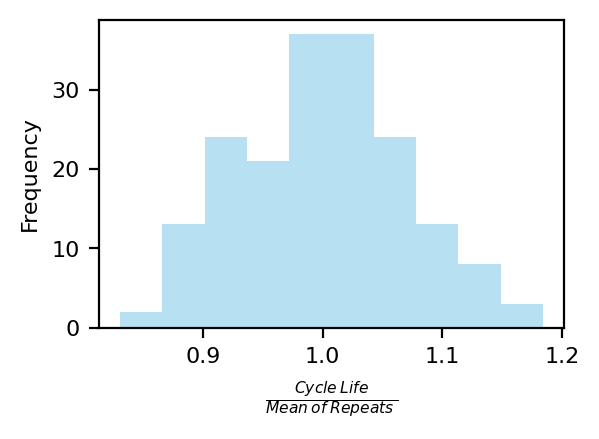

In [31]:
fig = plt.subplots(figsize = (3,2), dpi = 200)
plt.hist(new_df['metric'].to_numpy(), color='skyblue', alpha = 0.6)
font = 8
plt.xlabel(r'$\frac{Cycle\: Life}{Mean\:of\:Repeats \:}$', fontsize = font)
plt.ylabel('Frequency',  fontsize = font)
plt.tick_params(axis='both', which = 'both', labelsize=font) 
# plt.savefig('Figs/cell_variation.pdf', transparent = True, bbox_inches='tight')

#### Repeatability of the first cycle RPT C/20 discharge capacity 

In [32]:
new_df = pd.DataFrame(columns = ['seq_num', 'cycle_life', 'mean'], index = range(len(df_one.seq_num.unique())))
df_rpt_0 = df_rpt[df_rpt.cycle_index == 0]

l = 0
name = 'rpt_low_cap'
for i in range(len(repeats)):
    for seq_num in repeats[i]:
        new_df['seq_num'].iloc[l] = seq_num
        if len(df_one[df_one.seq_num == seq_num])>0:
            new_df['cycle_life'].iloc[l] = df_rpt_0[df_rpt_0.seq_num == seq_num][name].iloc[0]
            new_df['mean'].iloc[l] = df_rpt_0[df_rpt_0.seq_num.isin(repeats[i])][name].mean()
        l += 1

new_df = new_df[new_df.seq_num.isin(batch_1)]
new_df['metric'] = new_df['cycle_life']/new_df['mean']

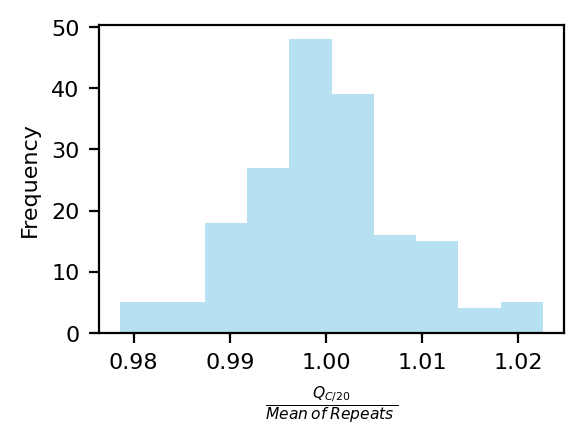

In [33]:
fig = plt.subplots(figsize = (3,2), dpi = 200)
plt.hist(new_df['metric'].to_numpy(), color='skyblue', alpha = 0.6)
font = 8
plt.xlabel(r'$\frac{Q_{C/20}}{Mean\:of\:Repeats \:}$', fontsize = font)
plt.ylabel('Frequency',  fontsize = font)
plt.tick_params(axis='both', which = 'both', labelsize=font) 
# plt.savefig('Figs/capacity_variation.pdf', transparent = True, bbox_inches='tight')

### Fig 3(a)

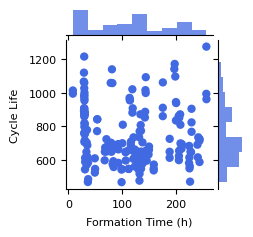

In [12]:
df_all_0 = df_all[df_all.cycle_index == 0]
chosen = df_all_0[(df_all_0.seq_num.isin(batch_1))]
chosen['formation_time_all'] = chosen.formation_time + chosen.ocv_time
sns.jointplot(data=chosen, x="formation_time_all", y="regu_life", color = 'royalblue', edgecolor = 'none')

font_size_set = 8
plt.rc('font', size=font_size_set)          # controls default text sizes  
plt.rc('axes', labelsize=font_size_set)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size_set)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size_set)    # fontsize of the tick labels  
plt.xlabel('Formation Time (h)', fontsize = 8, labelpad = 6)
plt.ylabel('Cycle Life', fontsize = 8, labelpad = 6)
plt.rcParams['patch.edgecolor'] = 'none'

fig = plt.gcf()
# Set the figure size
fig.set_size_inches(2,2)  # Replace width and height with your desired values
# Show the plot
plt.savefig('Figs/time_cyclelife.svg', transparent = True, bbox_inches='tight', dpi = 300)

### Figure 5d

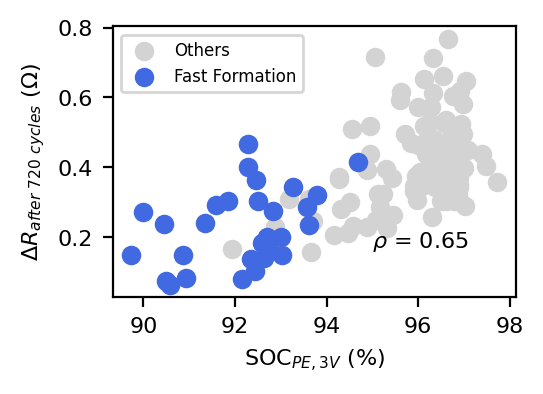

In [16]:
r = 'r_d_0_10s'

num_cols = 1
num_rows = 1
fig, axs = plt.subplots(num_rows, num_cols, figsize=(7.8/3*num_cols, 1.76*num_rows), dpi = 200)
df_all = df_f_info.merge(df_param, on = 'seq_num')
df_all = df_all.merge(df_rpt, on = 'seq_num')
df_all = df_all.merge(df_one, on = 'seq_num')
df_all = df_all.merge(df_diff, on = ['seq_num', 'cycle_index'])
df_all = df_all[df_all.seq_num.isin(batch_1)]

df_chosen = df_all[(df_all.cycle_index == 745)&(df_all[r].notna())&(df_all.formation_temperature<55)].copy()[['seq_num', r]]
df_e = df_electrode_info[df_electrode_info.cycle_index == 0].copy()
df_new = df_e.merge(df_chosen, on = 'seq_num')
x = df_new['SOC_pe_0']
y = df_new[r]
corr = scipy.stats.pearsonr(x, y)[0]
axs.scatter(x, y, color = 'lightgrey', label = 'Others')

df_chosen = df_all[(df_all.cycle_index == 745)&(df_all[r].notna())
                   &(df_all.formation_temperature<55)&(df_all.formation_charge_current_1>=0.24)&(df_all.formation_charge_current_2>=0.24)][['seq_num', r]]
df_new = df_e.merge(df_chosen, on = 'seq_num')
x = df_new['SOC_pe_0']
y = df_new[r]
font = 8 
axs.scatter(x, y, color = 'royalblue', label = 'Fast Formation')
axs.set_xlabel('SOC$_{PE, 3V}$ (%)', fontsize = font)
axs.set_ylabel('$\Delta R_{after\ 720\ cycles}$ (\u03A9)', fontsize = font)
axs.tick_params(axis='y', labelsize=8)
axs.tick_params(axis='x', labelsize=8)
axs.text(95, 0.17, r'$\rho$'+ ' = '  + str(round(corr, 2)), fontsize = font)
axs.legend(loc = 'best', fontsize = 6)

# plt.savefig('Figs/4_c.svg', transparent = True, bbox_inches='tight', dpi = 500)

### Figure SI

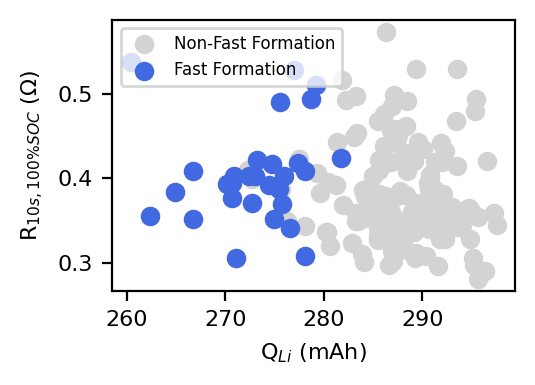

In [15]:
r = 'r_d_0_10s'

num_cols = 1
num_rows = 1
fig, axs = plt.subplots(num_rows, num_cols, figsize=(7.8/3*num_cols, 1.76*num_rows), dpi = 200)
df_all = df_f_info.merge(df_param, on = 'seq_num')
df_all = df_all.merge(df_rpt, on = 'seq_num')
df_all = df_all.merge(df_one, on = 'seq_num')
df_all = df_all.merge(df_diff, on = ['seq_num', 'cycle_index'])
df_all = df_all[df_all.seq_num.isin(batch_1)]

df_chosen = df_all[(df_all.cycle_index == 0)&(df_all[r].notna())&(df_all.seq_num!= 270)].copy()[['seq_num', r]]
df_e = df_electrode_info[df_electrode_info.cycle_index == 0].copy()
df_new = df_e.merge(df_chosen, on = 'seq_num')
x = df_new['Q_li']
y = df_new[r]
corr = scipy.stats.pearsonr(x, y)[0]
axs.scatter(x, y, color = 'lightgrey', label = 'Non-Fast Formation')

df_chosen = df_all[(df_all.cycle_index == 0)&(df_all[r].notna())
                   &(df_all.formation_temperature<55)&(df_all.formation_charge_current_1>=0.24)&(df_all.formation_charge_current_2>=0.24)][['seq_num', r]]
df_new = df_e.merge(df_chosen, on = 'seq_num')
x = df_new['Q_li']
y = df_new[r]
font = 8 
axs.scatter(x, y, color = 'royalblue', label = 'Fast Formation')
axs.set_xlabel('Q$_{Li}$ (mAh)', fontsize = font)
axs.set_ylabel('R$_{10s, 100\% SOC}$ (\u03A9)', fontsize = font)
axs.tick_params(axis='y', labelsize=8)
axs.tick_params(axis='x', labelsize=8)
# axs.text(95, 0.17, 'corr =' + str(round(corr, 2)), fontsize = font)
axs.legend(loc = 'best', fontsize = 6)

# plt.savefig('Figs/SI_R_bol.pdf', transparent = True, bbox_inches='tight', dpi = 500)